# Work in Progress to plot results

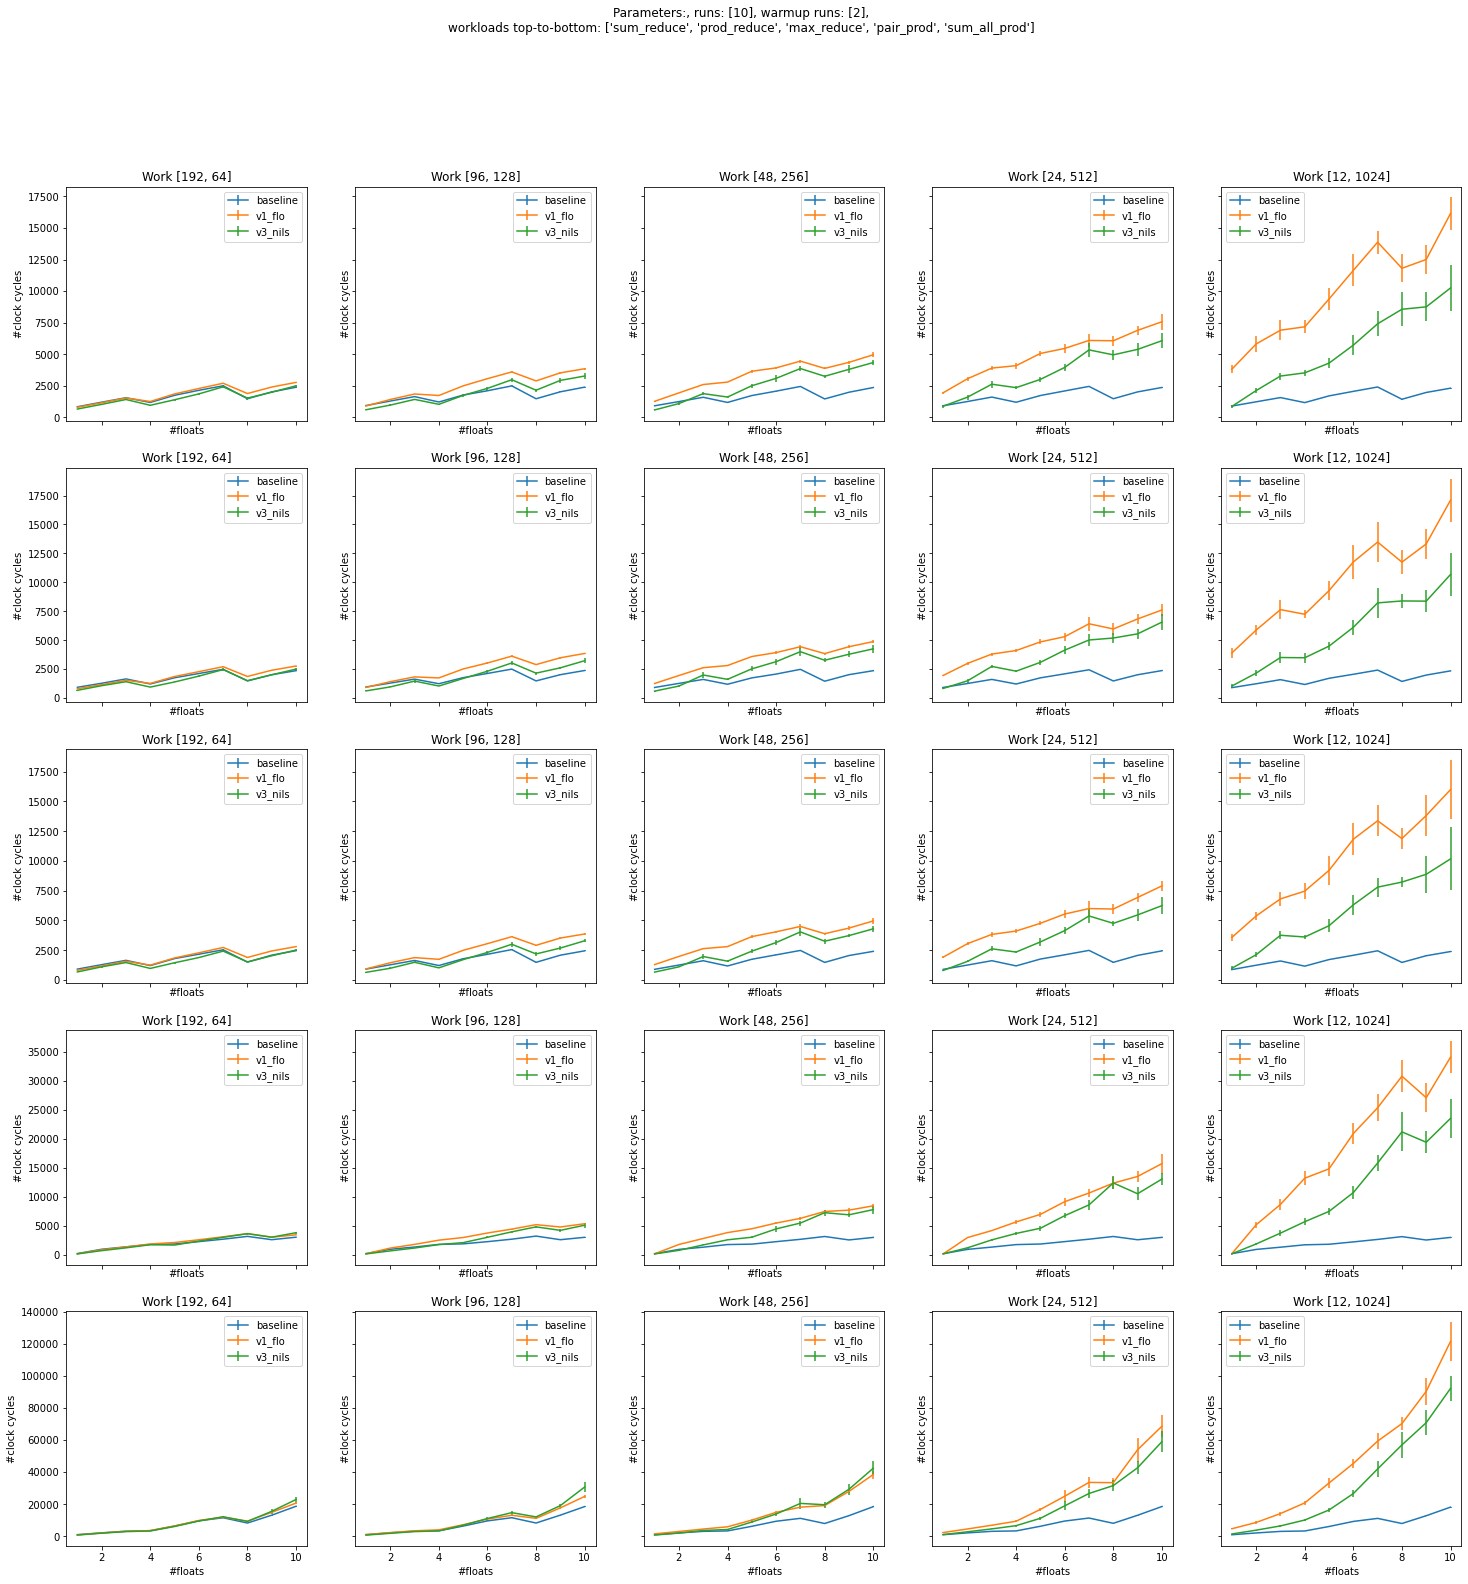

In [9]:
#!/usr/bin/env python
# coding: utf-8

# Plot benchmarks using existing run data

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys


#CSV_PATH = sys.argv[1]
CSV_PATH = "results/2021-12-12-12:30:06"

header = ['version', 'workload', 'runs', 'warmup', 'blocks', 'threads_per_block', 'num_floats', 'malloc_mean', 'malloc_max', 'free_mean', 'free_max', 'work_mean', 'work_max']
df = pd.read_csv(CSV_PATH+"/out.csv", names = header, header = 0, delimiter = ' ')


# single plot
def plot_floats_vs_cycles(df, ax, params):
    
    measurement_type = params['measurement_type'] # is either "Malloc", "Work", or "Free"
    
    # filter for data that fits the given parameters
    block_mask = df['blocks'] == params['blocks']
    threads_mask = df['threads_per_block'] == params['threads_per_block']
    workload_mask = df['workload'] == params['workload']
    df = df[block_mask & threads_mask & workload_mask]
    
    if params['num_floats'] >= 0:
        float_mask = df['num_floats'] <= params['num_floats']
        df = df[float_mask]
    
    
    # calculate mean and std over all runs
    df = df.groupby(['num_floats', 'version'], as_index=False)\
           .agg({'malloc_mean':['mean','std'], 'malloc_max':['mean', 'std'],\
                 'free_mean':['mean','std'],   'free_max':['mean', 'std'],\
                 'work_mean':['mean','std'],   'work_max':['mean', 'std']}\
               )
    
   
    floats = list(df['num_floats'].unique())
    
    if 'Malloc' == params['measurement_type']:
        ax.set_title("Malloc")
        
        for version in list(df['version'].unique()):
            mean = df[df['version'] == version]['malloc_mean']['mean']
            std = df[df['version'] == version]['malloc_mean']['std']
            ax.errorbar(floats, mean, std, label=str(version))
            
    elif 'Free' == params['measurement_type']:
        ax.set_title("Free")
        
        for version in list(df['version'].unique()):
            mean = df[df['version'] == version]['free_mean']['mean']
            std = df[df['version'] == version]['free_mean']['std']
            ax.errorbar(floats, mean, std, label=str(version))
        
    elif 'Work' == params['measurement_type']:
        ax.set_title("Work")
        
        for version in list(df['version'].unique()):
            mean = df[df['version'] == version]['work_mean']['mean']
            std = df[df['version'] == version]['work_mean']['std']
            ax.errorbar(floats, mean, std, label=str(version))
        
    
    ax.legend()
    ax.set_xlabel("#floats")
    ax.set_ylabel("#clock cycles")
    
    
    
# extract range of parameters
versions = list(df['version'].unique())
workloads = list(df['workload'].unique())
runs = list(df['runs'].unique())
warmups = list(df['warmup'].unique())
blocks = list(df['blocks'].unique())
threads_per_block = list(df['threads_per_block'].unique())
num_floats = list(df['num_floats'].unique())
measurement_types = ['Malloc', 'Work', 'Free']

def plot_workloads_vs_measurement_type():
    ## plot (workloads) vs (malloc, work, free)
    fig, axs = plt.subplots(len(workloads), 3, sharey=False, sharex=True, figsize=(15, len(workloads)*5))
    # constant parameters
    n_blocks = 192
    n_threads_per_block = 64
    n_floats = 10
    fig.suptitle("Parameters:" \
              + " blocks: " + str(n_blocks)\
              + ", threads per block: " + str(n_threads_per_block)\
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n"\
              + "workloads top-to-bottom: " + str(workloads))
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    for w, workload in enumerate(workloads):
        for i, measurement_type in enumerate(measurement_types):
            params = {'measurement_type': measurement_type,
                      'blocks': 192,
                      'threads_per_block': 64,
                      'workload': workload,
                      'num_floats': n_floats}
            plot_floats_vs_cycles(df, axs[w][i], params)

    plt.savefig(CSV_PATH+"/workload_vs_measurement_type.png", dpi=60, bbox_inches='tight')   
    plt.show()

def plot_blocks_vs_threads_per_block():
    ## plot (blocks) vs (threads_per_block)
    fig, axs = plt.subplots(len(workloads), len(threads_per_block), sharey='row', sharex=True, figsize=(len(workloads)*5, len(threads_per_block)*5))
    # constant parameters
    n_floats = 10
    
    fig.suptitle("Parameters:" \
              + ", runs: " + str(runs)\
              + ", warmup runs: " + str(warmups) + ",\n"\
              + "workloads top-to-bottom: " + str(workloads))
    #fig.supxlabel('Measurement type')
    #fig.supylabel('Workload')

    for w, workload in enumerate(workloads):
        for b, block in enumerate(blocks):
        
            params = {'measurement_type': 'Work',
                      'blocks': block,
                      'threads_per_block': threads_per_block[b],
                      'workload': workload,
                      'num_floats': n_floats}
            plot_floats_vs_cycles(df, axs[w][b], params)
            axs[w][b].set_title("Work ["+str(block)+", "+str(threads_per_block[b])+"]")

    plt.savefig(CSV_PATH+"/blocks_vs_threads_per_block_vs_workload.png", dpi=60, bbox_inches='tight')   
    plt.show()

    
#plot_workloads_vs_measurement_type()
plot_blocks_vs_threads_per_block()